In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
BASE_DRIVE_PATH = "/content/drive/MyDrive/U.S. Airline On-Time analysis Data"

In [11]:
# === Parameters ===
USE_SAMPLE_MODE = False
SAMPLE_FRACTION = 0.01
MIN_VALID_ARR_DELAY = -300
MAX_VALID_ARR_DELAY = 300
AUTO_SENTINEL_MIN_FREQ = 50
SAVE_OUTPUTS = True
OUTPUT_DIR_NAME = "analysis_dashboard_outputs_cleaned"
HDFS_BASE_EXAMPLE = "hdfs://namenode:8020/user/<your_user>/airline_data"
HDFS_OUTPUT_EXAMPLE = "hdfs://namenode:8020/user/<your_user>/analysis_outputs"


In [12]:
import os

plots_dir = "/content/drive/MyDrive/U.S. Airline On-Time analysis Data/results_plot"   # or any folder you like
os.makedirs(plots_dir, exist_ok=True)

print("Saving all plots to:", plots_dir)


Saving all plots to: /content/drive/MyDrive/U.S. Airline On-Time analysis Data/results_plot


In [5]:
%%bash
set -euo pipefail
echo "=== Fast Spark setup (pip-only pyspark) ==="

# Clean some caches that sometimes cause long installs
python3 -m pip cache purge || true

echo "Installing Java (OpenJDK 11) and required Python packages..."
apt-get update -qq
apt-get install -y -qq openjdk-11-jdk-headless

# Install pyspark wheel only (no large .tgz extraction). This is usually much faster.
python3 -m pip install -q --upgrade pip
python3 -m pip install -q "pyspark[connect]==3.5.1" findspark pyarrow pandas plotly matplotlib seaborn nbformat

echo "Environment variables for this shell"
export JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64
export PYSPARK_PYTHON=$(which python3)
echo "JAVA_HOME=${JAVA_HOME}"
echo "PYSPARK_PYTHON=${PYSPARK_PYTHON}"

echo "Starting a quick Python check to init Spark"
python3 - <<'PY'
import os, platform, sys
os.environ.setdefault("JAVA_HOME", "/usr/lib/jvm/java-11-openjdk-amd64")
os.environ.setdefault("PYSPARK_PYTHON", sys.executable)

print("Python exe:", sys.executable)
print("Python version:", platform.python_version())
print("JAVA_HOME:", os.environ.get("JAVA_HOME"))

import findspark
# findspark.init() is optional when using pip-installed pyspark, but harmless
try:
    findspark.init()
except Exception:
    pass

from pyspark.sql import SparkSession
# use smaller driver memory to reduce chance of resource issues on Colab
driver_mem = "2g"
spark = SparkSession.builder \
    .appName("AirlineOnTime_Enhanced_fast") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", driver_mem) \
    .getOrCreate()

print("Spark version:", spark.version)
print("Spark master:", spark.sparkContext.master)
print("Driver memory:", driver_mem)
spark.stop()
print("Done.")
PY

echo "Fast setup finished."


=== Fast Spark setup (pip-only pyspark) ===
Files removed: 0
Installing Java (OpenJDK 11) and required Python packages...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/20 23:44:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
import os, platform
from pyspark.sql import SparkSession


os.environ.setdefault("JAVA_HOME", "/usr/lib/jvm/java-11-openjdk-amd64")
os.environ.setdefault("PYSPARK_PYTHON", "/usr/bin/python3")

spark = SparkSession.builder \
    .appName("AirlineOnTime_Enhanced") \
    .config("spark.sql.shuffle.partitions", 8) \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("Spark version:", spark.version)
print("Master:", spark.sparkContext.master)
print("Python version:", platform.python_version())


Spark version: 3.5.1
Master: local[*]
Python version: 3.12.12


In [14]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('AirlineOnTime_Enhanced')\
    .config('spark.sql.shuffle.partitions','8')\
    .config('spark.driver.memory','4g').getOrCreate()
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')
print('Spark version:', spark.version)
print('Python version:', platform.python_version())


Spark version: 3.5.1
Python version: 3.12.12


In [15]:
# === Discover CSV files and provenance ===
import glob, pandas as pd
from pathlib import Path

base = BASE_DRIVE_PATH
subfolders = [p for p in Path(base).iterdir() if p.is_dir()]
csv_files = [str(f) for s in subfolders for f in s.glob('*.csv')]
print('CSV files found:', len(csv_files))

prov = [(f, Path(f).stat().st_size/1024/1024) for f in csv_files]
prov_df = pd.DataFrame(prov, columns=['path','size_mb']).sort_values('size_mb', ascending=False)
display(prov_df.head(10))

if SAVE_OUTPUTS:
    out_dir = os.path.join(base, OUTPUT_DIR_NAME)
    os.makedirs(out_dir, exist_ok=True)
    prov_df.to_csv(os.path.join(out_dir,'provenance_summary.csv'), index=False)


CSV files found: 66


,path,size_mb
35,/content/drive/MyDrive/U.S. Airline On-Time an...,101.478164
44,/content/drive/MyDrive/U.S. Airline On-Time an...,98.651114
30,/content/drive/MyDrive/U.S. Airline On-Time an...,98.386619
32,/content/drive/MyDrive/U.S. Airline On-Time an...,97.966307
41,/content/drive/MyDrive/U.S. Airline On-Time an...,97.806659
29,/content/drive/MyDrive/U.S. Airline On-Time an...,97.411515
28,/content/drive/MyDrive/U.S. Airline On-Time an...,97.350594
40,/content/drive/MyDrive/U.S. Airline On-Time an...,96.443266
42,/content/drive/MyDrive/U.S. Airline On-Time an...,95.583587
34,/content/drive/MyDrive/U.S. Airline On-Time an...,94.958697


In [16]:
# === Read data into Spark ===
sample_df = spark.read.option('header','true').option('inferSchema','true').csv(csv_files[:5])
schema = sample_df.schema

if USE_SAMPLE_MODE:
    raw_df = spark.read.option('header','true').schema(schema).csv(csv_files)
    df = raw_df.sample(False, SAMPLE_FRACTION, seed=42)
else:
    df = spark.read.option('header','true').schema(schema).csv(csv_files)

print('Rows:', df.count())


Rows: 34786532


In [17]:
# === Normalize columns and parse FL_DATE ===
from pyspark.sql.functions import col, trim, to_timestamp, to_date, concat_ws, lpad, when, coalesce as _coalesce

df = df.select([col(c).alias(c.strip()) for c in df.columns])
num_cols = ['DEP_DELAY','ARR_DELAY','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
for c in num_cols:
    if c in df.columns:
        df = df.withColumn(c, col(c).cast('double'))

fl = trim(col('FL_DATE').cast('string'))
formats = ['MM-dd-yyyy HH:mm','MM/dd/yyyy hh:mm:ss a','M/d/yyyy h:mm:ss a','yyyy-MM-dd HH:mm:ss']
df = df.withColumn('FL_DATE_TS', _coalesce(*[to_timestamp(fl,f) for f in formats]))
df = df.withColumn('FL_DATE', to_date(col('FL_DATE_TS')))
print('Null FL_DATE:', df.filter(col('FL_DATE').isNull()).count())


Null FL_DATE: 1645503


In [18]:
# === Join cancellation lookup ===
import os
cancel_path = os.path.join(BASE_DRIVE_PATH, 'L_CANCELLATION.csv')
if os.path.exists(cancel_path):
    cancel_df = spark.read.option('header','true').csv(cancel_path)
    cancel_df = cancel_df.withColumnRenamed('Code','CANCELLATION_CODE').withColumnRenamed('Description','CANCELLATION_REASON')
    df = df.join(cancel_df, on='CANCELLATION_CODE', how='left')
    print('Joined cancellation reasons')


Joined cancellation reasons


In [19]:
# === Sentinel detection and removal ===
from pyspark.sql.functions import count as _count, when

freq_large = df.filter(col('ARR_DELAY') >= 300).groupBy('ARR_DELAY').agg(_count('*').alias('cnt')).orderBy(col('cnt').desc())
freq_large.show(10)

total = df.count()
thresh = max(AUTO_SENTINEL_MIN_FREQ, int(0.001 * total))
sentinels = [float(r['ARR_DELAY']) for r in freq_large.filter(col('cnt') >= thresh).collect()]
print('Sentinels:', sentinels)

if sentinels:
    df = df.filter(~col('ARR_DELAY').isin(sentinels))
df = df.filter(col('ARR_DELAY').between(MIN_VALID_ARR_DELAY, MAX_VALID_ARR_DELAY))
df = df.withColumn('is_delayed', when(col('ARR_DELAY') > 15, 1).otherwise(0))
print('After cleaning:', df.count())


+---------+-----+
|ARR_DELAY|  cnt|
+---------+-----+
|   1633.0|23131|
|   1640.0|23109|
|   1632.0|23102|
|   1634.0|23041|
|   1630.0|23008|
|   1638.0|22996|
|   1631.0|22992|
|   1635.0|22978|
|   1641.0|22933|
|   1637.0|22922|
+---------+-----+
only showing top 10 rows

Sentinels: []
After cleaning: 13737055


In [20]:
# === Final summary ===
print('Final rows:', df.count())
print('Columns:', df.columns)
assert df.filter(col('ARR_DELAY') > MAX_VALID_ARR_DELAY).count() == 0
print('Notebook run complete.')

Final rows: 13737055
Columns: ['CANCELLATION_CODE', 'YEAR', 'MONTH', 'DAY_OF_MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST_CITY_MARKET_ID', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DATE_TS', 'CANCELLATION_REASON', 'is_delayed']
Notebook run complete.


In [21]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kaleido]


In [22]:
!pip install --upgrade plotly
!pip install --upgrade kaleido


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 117.8 MB/s  0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [50]:
from pyspark.sql.functions import year, month, sum as _sum, count
import plotly.express as px

# 1) Create the monthly dataframe
monthly = (
    df.groupBy(year('FL_DATE').alias('year'), month('FL_DATE').alias('month'))
      .agg((_sum('is_delayed')/count('*')*100).alias('pct_delayed'))
      .orderBy('year','month')
)
monthly_pd = monthly.toPandas()

# 2) Create the figure
fig = px.line(
    monthly_pd,
    x='month',
    y='pct_delayed',
    color='year',
    title='Monthly % Delayed (Cleaned)'
)

# 3) Adjust layout (so nothing gets cut off)
fig.update_layout(
    margin=dict(l=40, r=140, t=60, b=60)  # right margin bigger
)

# 4) Show the figure
fig.show()
fig.write_html(f"{plots_dir}/monthly_delay.html")

In [51]:
# === Average Arrival Delay by Carrier ===
from pyspark.sql.functions import avg, col, sum as _sum, count
import plotly.express as px

carrier_delay = (
    df.groupBy('OP_UNIQUE_CARRIER')
      .agg(avg('ARR_DELAY').alias('avg_arr_delay'),
           (_sum('is_delayed')/count('*')*100).alias('pct_delayed'))
      .orderBy(col('avg_arr_delay').desc())
)

carrier_pd = carrier_delay.toPandas()

fig = px.bar(
    carrier_pd,
    x='OP_UNIQUE_CARRIER',
    y='avg_arr_delay',
    color='pct_delayed',
    title='Average Arrival Delay by Airline (Carrier)',
)

fig.show()
fig.write_html(f"{plots_dir}/avg_arr_delay_by_carrier")



In [52]:
# === Top 15 Origin Airports by % Delayed ===
origin_delay = (df.groupBy('ORIGIN_CITY_NAME')
                  .agg((_sum('is_delayed')/count('*')*100).alias('pct_delayed'),
                       count('*').alias('total_flights'))
                  .filter(col('total_flights') > 1000)
                  .orderBy(col('pct_delayed').desc())
                  .limit(15))

origin_pd = origin_delay.toPandas()

fig = px.bar(
    origin_pd,
    x='ORIGIN_CITY_NAME', y='pct_delayed',
    title='Top 15 Airports by % Delayed Departures',
    labels={'pct_delayed':'% Delayed','ORIGIN_CITY_NAME':'Origin Airport'},
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()
fig.write_html(f"{plots_dir}/Top_15_Origin_Airports_by_%_Delayed")


In [53]:
# === Delay Cause Contribution Pie Chart ===
cause_cols = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
df_causes = df.select(*[col(c) for c in cause_cols])

cause_sums = df_causes.agg(*[_sum(c).alias(c) for c in cause_cols]).toPandas().iloc[0]
cause_pd = pd.DataFrame({'Cause': cause_sums.index, 'TotalDelayMin': cause_sums.values})
fig = px.pie(cause_pd, names='Cause', values='TotalDelayMin', title='Delay Cause Breakdown')
fig.show()
fig.write_html(f"{plots_dir}/Delay_Cause_Contribution_Pie_Chart")


In [54]:
# === Average Delay by Day of Week ===
from pyspark.sql.functions import date_format

df_day = df.withColumn('DAY_OF_WEEK', date_format(col('FL_DATE'), 'E'))
dow_delay = (df_day.groupBy('DAY_OF_WEEK')
              .agg(avg('ARR_DELAY').alias('avg_arr_delay'),
                   (_sum('is_delayed')/count('*')*100).alias('pct_delayed'))
              .orderBy('DAY_OF_WEEK'))

dow_pd = dow_delay.toPandas()
fig = px.bar(dow_pd, x='DAY_OF_WEEK', y='avg_arr_delay',
             color='pct_delayed', title='Average Delay by Day of Week')
fig.show()
fig.write_html(f"{plots_dir}/Average_Delay_by_Day_of_Week")


In [55]:
# === Average Delay by Scheduled Departure Hour ===
from pyspark.sql.functions import substring

df_hour = df.withColumn('DEP_HOUR', (col('CRS_DEP_TIME')/100).cast('int'))
hour_delay = (df_hour.groupBy('DEP_HOUR')
              .agg(avg('ARR_DELAY').alias('avg_arr_delay'),
                   (_sum('is_delayed')/count('*')*100).alias('pct_delayed'))
              .orderBy('DEP_HOUR'))

hour_pd = hour_delay.toPandas()
fig = px.line(hour_pd, x='DEP_HOUR', y='avg_arr_delay',
              title='Average Arrival Delay by Departure Hour',
              labels={'DEP_HOUR':'Scheduled Departure Hour','avg_arr_delay':'Avg Delay (min)'})
fig.update_traces(mode='lines+markers')
fig.show()
fig.write_html(f"{plots_dir}/Average_Delay_by_Scheduled_Departure_Hour")


In [56]:
# === Delay Causes by Year ===
yearly_causes = (df.groupBy(year('FL_DATE').alias('year'))
                   .agg(*[_sum(c).alias(c) for c in cause_cols])
                   .orderBy('year'))

yearly_causes_pd = yearly_causes.toPandas().melt(id_vars=['year'], var_name='Cause', value_name='Minutes')
fig = px.bar(yearly_causes_pd, x='year', y='Minutes', color='Cause', barmode='stack',
             title='Delay Causes by Year')
fig.show()
fig.write_html(f"{plots_dir}/Top_15_Origin_Airports_by_%_Delayed")
fig.write_html(f"{plots_dir}/Delay_Causes_by_Year")

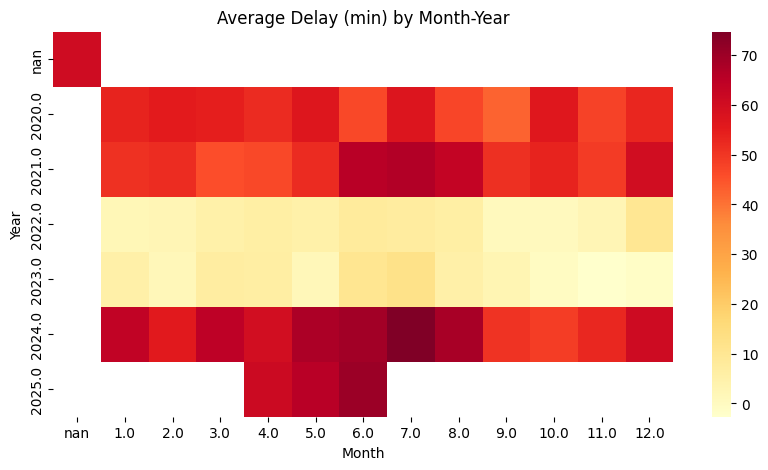

In [57]:
# === Delay Heatmap (Month-Year) ===
heatmap = (df.groupBy(year('FL_DATE').alias('year'), month('FL_DATE').alias('month'))
             .agg(avg('ARR_DELAY').alias('avg_delay')).orderBy('year','month'))
heatmap_pd = heatmap.toPandas().pivot(index='year', columns='month', values='avg_delay')

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.heatmap(heatmap_pd, cmap='YlOrRd', annot=False)
plt.title('Average Delay (min) by Month-Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()
fig.write_html(f"{plots_dir}/Delay_Heatmap_month")


In [58]:
# === On-Time Performance by Month ===
ontime = (df.groupBy(year('FL_DATE').alias('year'), month('FL_DATE').alias('month'))
             .agg(((1-_sum('is_delayed')/count('*'))*100).alias('pct_ontime'))
             .orderBy('year','month'))

ontime_pd = ontime.toPandas()
fig = px.line(ontime_pd, x='month', y='pct_ontime', color='year',
              title='On-Time Performance by Month',
              labels={'pct_ontime':'% On-Time Flights'})
fig.update_traces(mode='lines+markers')
fig.show()
fig.write_html(f"{plots_dir}/On-Time_Performance_by_Month")


In [59]:
# === Delay Duration Categories Pie ===
from pyspark.sql.functions import when, col, count
import plotly.express as px

# Recreate the category column
df_cat = df.withColumn(
    'delay_category',
    when(col('ARR_DELAY') <= 0, 'On-Time')
    .when(col('ARR_DELAY') <= 15, 'Slight (1–15 min)')
    .when(col('ARR_DELAY') <= 60, 'Moderate (16–60 min)')
    .when(col('ARR_DELAY') <= 180, 'Severe (1–3 hrs)')
    .otherwise('Extreme (>3 hrs)')
)

cat_pd = (
    df_cat.groupBy('delay_category')
    .agg(count('*').alias('count'))
    .orderBy('count', ascending=False)
    .toPandas()
)

import plotly.express as px
fig = px.pie(
    cat_pd,
    names='delay_category',
    values='count',
    title='Delay Duration Categories',
    hole=0.35,
    color_discrete_sequence=px.colors.qualitative.Set2,
    width=900,
    height=500
)

fig.update_traces(textinfo='label+percent', textposition='inside', textfont_size=13)
fig.update_layout(
    legend=dict(orientation='h', y=-0.15, x=0.5, xanchor='center'),
    margin=dict(l=20, r=20, t=60, b=80),
    title_x=0.02
)
fig.show()
fig.write_html(f"{plots_dir}/Delay_Duration_Categories_Pie")


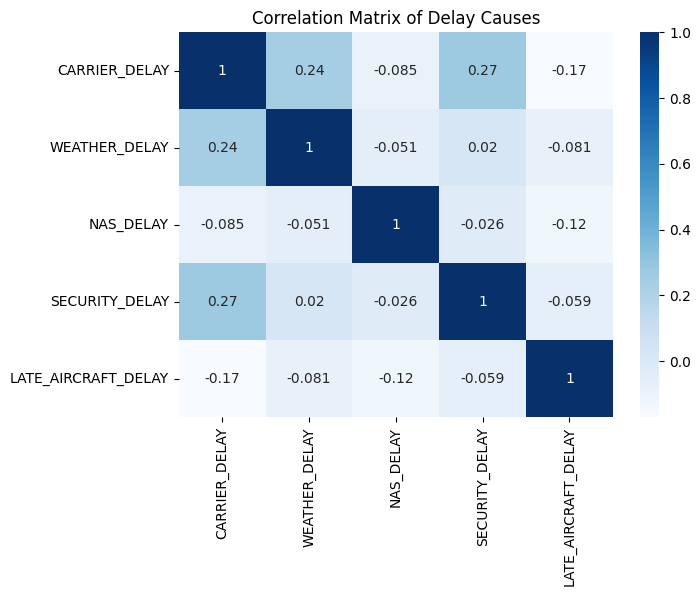

In [60]:
# === Correlation Matrix of Delay Causes ===
cause_pd = df.select(cause_cols).toPandas()
corr = cause_pd.corr(numeric_only=True)

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title('Correlation Matrix of Delay Causes')
plt.show()
fig.write_html(f"{plots_dir}/Correlation_Matrix_of_Delay_Causes")


In [61]:
# === Monthly Cancellation Trend ===
cancel_trend = (df.groupBy(year('FL_DATE').alias('year'), month('FL_DATE').alias('month'))
                  .agg((_sum('CANCELLED').alias('pct_cancelled')))
                  .orderBy('year','month'))
cancel_pd = cancel_trend.toPandas()
fig = px.line(cancel_pd, x='month', y='pct_cancelled', color='year',
              title='Monthly Cancellation Rate Over Years')
fig.show()
fig.write_html(f"{plots_dir}/Monthly_Cancellation_Trend")


In [62]:
# === Relationship Between Flight Distance and Delay ===
dist_delay = (df.groupBy('DISTANCE')
                .agg(avg('ARR_DELAY').alias('avg_arr_delay'))
                .filter(col('DISTANCE') <= 3000)
                .orderBy('DISTANCE'))
dist_pd = dist_delay.toPandas()
fig = px.scatter(dist_pd, x='DISTANCE', y='avg_arr_delay',
                 trendline='ols',
                 title='Average Delay vs. Flight Distance',
                 labels={'DISTANCE':'Distance (miles)','avg_arr_delay':'Avg Arrival Delay (min)'})
fig.show()
fig.write_html(f"{plots_dir}/Flight_Distance_and_Delay")

In [63]:
# === Quarterly Delay Rates ===
from pyspark.sql.functions import quarter
quarterly = (df.groupBy(year('FL_DATE').alias('year'), quarter('FL_DATE').alias('quarter'))
               .agg((_sum('is_delayed')/count('*')*100).alias('pct_delayed'))
               .orderBy('year','quarter'))
quarter_pd = quarterly.toPandas()
fig = px.bar(quarter_pd, x='quarter', y='pct_delayed', color='year',
             barmode='group', title='Quarterly Delay Percentage by Year')
fig.show()
fig.write_html(f"{plots_dir}/Quarterly_Delay_Rates")


In [64]:
# === Overall On-Time vs. Delayed Ratio ===
overall_counts = df.groupBy('is_delayed').agg(count('*').alias('count')).toPandas()
overall_counts['status'] = overall_counts['is_delayed'].map({1:'Delayed (>15 min)',0:'On-Time'})
fig = px.pie(overall_counts, names='status', values='count',
             title='Overall On-Time vs. Delayed Flights')
fig.update_layout(
    width=700,   # change width
    height=500,  # change height
    title_font_size=20
)
fig.show()
fig.write_html(f"{plots_dir}/On-Time_vs._Delayed Ratio")


In [66]:
import os
os.makedirs("/content/drive/MyDrive/U.S. Airline On-Time analysis Data/dashboard_folder", exist_ok=True)
print("Dashboard folder created successfully!")



Dashboard folder created successfully!


In [67]:
!pip install dash==2.14.2
!pip install jupyter-dash


In [74]:
import os

plots_dir = "/content/drive/MyDrive/U.S. Airline On-Time analysis Data/results_plot"
print("Plots dir:", plots_dir)
print(os.listdir(plots_dir))


Plots dir: /content/drive/MyDrive/U.S. Airline On-Time analysis Data/results_plot
['On-Time_vs._Delayed Ratio', 'Flight_Distance_and_Delay', 'avg_arr_delay_by_carrier', 'monthly_delay.html', 'Top_15_Origin_Airports_by_%_Delayed', 'Delay_Cause_Contribution_Pie_Chart', 'Average_Delay_by_Day_of_Week', 'Average_Delay_by_Scheduled_Departure_Hour', 'Delay_Causes_by_Year', 'Delay_Heatmap_month', 'On-Time_Performance_by_Month', 'Delay_Duration_Categories_Pie', 'Correlation_Matrix_of_Delay_Causes', 'Monthly_Cancellation_Trend', 'Quarterly_Delay_Rates']


In [75]:
import os
from dash import Dash, dcc, html
from google.colab import output
import time

PLOTS_DIR = "/content/drive/MyDrive/U.S. Airline On-Time analysis Data/results_plot"

def load_html(filename):
    """Read an HTML file from results_plot folder."""
    path_with_ext = os.path.join(PLOTS_DIR, filename + ".html")
    path_without_ext = os.path.join(PLOTS_DIR, filename)

    if os.path.exists(path_with_ext):
        path = path_with_ext
    elif os.path.exists(path_without_ext):
         path = path_without_ext
    else:
         return (
             f"<div style='padding:15px; background-color:#fff0f5; border: 1px solid #ff69b4; "
             f"border-radius: 0.5rem; text-align:center;'>"
             f"<h4 style='color:#a0005a; margin-top:0; font-size:1em;'> Plot File Not Found: {filename}</h4>"
             f"<p style='color:#a0005a; font-size:0.8em;'>Check path: <code>{PLOTS_DIR}/{filename}(.html)</code></p>"
             f"</div>"
         )

    with open(path, "r", encoding="utf-8") as f:
        return f.read()

def create_iframe_tab(title, filename, height='420px', description=None):
    """
    Helper to create a standard tab content block with a graph and description.
    Default height bumped to 420px so charts are not clipped; override per-chart if needed.
    """
    content = [
        html.H4(title, style={
            'borderBottom': '2px solid #3b82f6', 'paddingBottom': '5px',
            'color': '#1f2937', 'fontSize': '1.1em', 'marginTop': '0.5rem'
        }),
        html.P(description, style={'color': '#6b7280', 'marginBottom': '10px', 'fontSize': '0.9em'}) if description else None,
        html.Div(
            # wrapper div ensures iframe can expand and not be clipped by parent
            children=[
                html.Iframe(
                    srcDoc=load_html(filename),
                    style={
                        "width": "100%",
                        # use both height and minHeight for better behavior
                        "height": height,
                        "minHeight": "320px",
                        "border": "none",
                        "borderRadius": "0.5rem",
                        "boxShadow": "0 2px 4px rgba(0,0,0,0.05)",
                        # allow the iframe to display fully without forcing inner scrollbars
                        "overflow": "visible",
                        "display": "block"
                    },
                    # allow fullscreen for complex charts if desired
                    title=title
                )
            ],
            style={
                # let wrapper expand with the iframe
                'overflow': 'visible',
                'height': 'auto',
                'paddingBottom': '8px'
            }
        ),
    ]
    return html.Div([item for item in content if item is not None], style={'marginBottom': '18px', 'width': '100%'})

# --- Dash App Layout ---
app = Dash(__name__)

app.layout = html.Div(
    style={
        "fontFamily": "'Inter', sans-serif",
        "maxWidth": "1400px",
        "margin": "0 auto",
        "padding": "15px",
        "backgroundColor": "#f9fafb"
    },
    children=[
        html.H1("✈ U.S. Airline On-Time Performance Dashboard",
                style={"textAlign": "center", "color": "#1e40af", "marginBottom": "5px", "fontSize": "2.2rem"}),

        html.P("Real-time analytics and insights into flight delays, cancellations, and key operational patterns.",
               style={"textAlign": "center", "color": "#6b7280", "marginBottom": "15px", "fontSize": "1.0rem"}),

        html.Div(
            style={
                "backgroundColor": "#ffffff",
                "borderRadius": "1rem",
                "padding": "10px",
                "boxShadow": "0 10px 15px -3px rgba(0, 0, 0, 0.1), 0 4px 6px -2px rgba(0, 0, 0, 0.05)"
            },
            children=[
                dcc.Tabs(id="dashboard-tabs", value='tab-1',
                         parent_style={"marginBottom": "5px"},
                         style={"height": "35px"},
                         children=[

                    # 1. SUMMARY TAB
                    dcc.Tab(label="🚀 Quick Summary", value='tab-1', children=[
                        html.Div(className='tab-content', style={'padding': '10px', 'overflow': 'visible', 'height': 'auto'}, children=[
                            html.H2("Key Performance Indicators (KPIs)", style={'color': '#1f2937', 'marginBottom': '10px', 'fontSize': '1.5em'}),

                            html.Div(style={'display': 'flex', 'gap': '15px', 'alignItems': 'flex-start', 'flexWrap': 'wrap'}, children=[
                                html.Div(style={'flex': '1 1 48%', 'minWidth': '300px'}, children=[
                                    # increase pie chart area
                                    create_iframe_tab(
                                        "Overall On-Time vs Delayed Flights",
                                        "On-Time_vs._Delayed Ratio",
                                        height='420px',
                                        description="A high-level view of what percentage of flights arrive on time versus those that experience any delay."
                                    ),
                                ]),
                                html.Div(style={'flex': '1 1 48%', 'minWidth': '300px'}, children=[
                                    create_iframe_tab(
                                        "Delay Cause Contribution Pie",
                                        "Delay_Cause_Contribution_Pie_Chart",
                                        height='420px',
                                        description="Breaks down the primary reasons for all delays (e.g., Carrier issues, Weather, Security, etc.)."
                                    ),
                                ]),
                            ]),
                        ])
                    ]),

                    # 2. TRENDS & TIME ANALYSIS
                    dcc.Tab(label="📈 Trends & Seasonal Analysis", value='tab-2', children=[
                        html.Div(className='tab-content', style={'padding': '10px', 'overflow': 'visible', 'height': 'auto'}, children=[
                            create_iframe_tab(
                                "Monthly % Delayed",
                                "monthly_delay.html",
                                height='520px',
                                description="Tracks the percentage of flights delayed month-over-month to identify seasonal peaks and troughs."
                            ),
                            create_iframe_tab(
                                "Average Delay by Month-Year (Heatmap)",
                                "Delay_Heatmap_month",
                                height='520px',
                                description="Visualizes the intensity of average delay minutes across different months and years."
                            ),
                            create_iframe_tab(
                                "Monthly Cancellation Rate by Year",
                                "Monthly_Cancellation_Trend",
                                height='480px',
                                description="Shows the trend in flight cancellation rates over time, useful for spotting structural or external issues."
                            ),
                        ])
                    ]),

                    # 3. CAUSES & OPERATIONS
                    dcc.Tab(label="⚠ Causes & Operational Deep Dive", value='tab-3', children=[
                        html.Div(className='tab-content', style={'padding': '10px', 'overflow': 'visible', 'height': 'auto'}, children=[
                            html.Div(style={'display': 'flex', 'gap': '15px', 'alignItems': 'flex-start', 'flexWrap': 'wrap'}, children=[
                                html.Div(style={'flex': '1 1 48%', 'minWidth': '300px'}, children=[
                                    create_iframe_tab(
                                        "Average Delay by Day of Week",
                                        "Average_Delay_by_Day_of_Week",
                                        height='480px',
                                        description="Identifies which days of the week experience the highest average delays."
                                    ),
                                ]),
                                html.Div(style={'flex': '1 1 48%', 'minWidth': '300px'}, children=[
                                    create_iframe_tab(
                                        "Average Arrival Delay by Departure Hour",
                                        "Average_Delay_by_Scheduled_Departure_Hour",
                                        height='480px',
                                        description="Shows how average delay changes based on the scheduled departure time of day."
                                    ),
                                ]),
                            ]),

                            create_iframe_tab(
                                "Delay Causes by Year",
                                "Delay_Causes_by_Year",
                                height='520px',
                                description="A yearly stacked view of the major contributing factors to delays (e.g., weather, carrier, NAS)."
                            ),
                            # Correlation Matrix set a little taller
                            create_iframe_tab(
                                "Delay Duration Categories Pie",
                                "Delay_Duration_Categories_Pie",
                                height='600px',
                                description="Shows how different delay causes relate to one another (e.g., does high air traffic delay correlate with high security delay?)."
                            ),
                        ])
                    ]),

                    # 4. CARRIER & AIRPORT PERFORMANCE
                    dcc.Tab(label="📊 Carrier & Airport Performance", value='tab-4', children=[
                        html.Div(className='tab-content', style={'padding': '10px', 'overflow': 'visible', 'height': 'auto'}, children=[
                            create_iframe_tab(
                                "Average Arrival Delay by Carrier",
                                "avg_arr_delay_by_carrier",
                                height='520px',
                                description="Compares the average arrival delay performance across all major US airlines."
                            ),
                            create_iframe_tab(
                                "Top 15 Origin Airports by % Delayed",
                                "Top_15_Origin_Airports_by_%_Delayed",
                                height='520px',
                                description="Ranks the airports with the highest percentage of delayed flights."
                            ),
                            create_iframe_tab(
                                "Flight Distance vs Delay",
                                "Flight_Distance_and_Delay",
                                height='520px',
                                description="Examines whether longer or shorter flights are more prone to delay."
                            ),
                        ])
                    ]),
                ])
            ]
        )
    ]
)

# --- Execution ---
if __name__ == "__main__":
    port = 8050
    print(f"Opening port {port} for Dash visualization...")
    output.serve_kernel_port_as_window(port=port, anchor_text='Click here to view the Interactive Flight Delay Dashboard')

    print("Starting Dash server...")
    # Use external mode so the dashboard opens in a browser window instead of being constrained inside the notebook cell.
    # If you prefer inline, change mode='external' back to 'inline'.
    app.run_server(mode='external', host="0.0.0.0", port=port, debug=False, dev_tools_hot_reload=False)


Opening port 8050 for Dash visualization...
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

Starting Dash server...


<IPython.core.display.Javascript object>

In [77]:
print("Thank You")

Thank You
